# Классификация отзывов IMDB

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import os
from keras.utils import np_utils
from tensorflow.keras.layers import Embedding, Conv1D, AveragePooling1D, Bidirectional, LSTM, Dense

In [2]:
from tensorflow.keras.layers import TextVectorization
import string
import re
from tensorflow.keras import layers

In [6]:
from collections import Counter
import seaborn as sns
import nltk
from nltk.corpus import stopwords

In [5]:
pip install nltk

     |████████████████████████████████| 1.5 MB 26.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Load the data: IMDB movie review sentiment classification

Let's download the data and inspect its structure.

In [4]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.7M      0  0:00:07  0:00:07 --:--:-- 18.0M


The `aclImdb` folder contains a `train` and `test` subfolder:

In [7]:
!ls aclImdb

imdbEr.txt  imdb.vocab	README	test  train


In [8]:
!ls aclImdb/test

labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


In [9]:
!ls aclImdb/train

labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


The `aclImdb/train/pos` and `aclImdb/train/neg` folders contain text files, each of
 which represents one review (either positive or negative):

In [10]:
!cat aclImdb/train/pos/6248_7.txt

Being an Austrian myself this has been a straight knock in my face. Fortunately I don't live nowhere near the place where this movie takes place but unfortunately it portrays everything that the rest of Austria hates about Viennese people (or people close to that region). And it is very easy to read that this is exactly the directors intention: to let your head sink into your hands and say "Oh my god, how can THAT be possible!". No, not with me, the (in my opinion) totally exaggerated uncensored swinger club scene is not necessary, I watch porn, sure, but in this context I was rather disgusted than put in the right context.<br /><br />This movie tells a story about how misled people who suffer from lack of education or bad company try to survive and live in a world of redundancy and boring horizons. A girl who is treated like a whore by her super-jealous boyfriend (and still keeps coming back), a female teacher who discovers her masochism by putting the life of her super-cruel "lover" 

We are only interested in the `pos` and `neg` subfolders, so let's delete the rest:

In [11]:
!rm -r aclImdb/train/unsup

In [12]:
for dir in range (8):
    os.mkdir(f'aclImdb/train/{dir}')

In [13]:
for dir in range (8):
    os.mkdir(f'aclImdb/test/{dir}')
!ls aclImdb/test 

0  1  2  3  4  5  6  7	labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


You can use the utility `tf.keras.utils.text_dataset_from_directory` to
generate a labeled `tf.data.Dataset` object from a set of text files on disk filed
 into class-specific folders.

Let's use it to generate the training, validation, and test datasets. The validation
and training datasets are generated from two subsets of the `train` directory, with 20%
of samples going to the validation dataset and 80% going to the training dataset.

Having a validation dataset in addition to the test dataset is useful for tuning
hyperparameters, such as the model architecture, for which the test dataset should not
be used.

Before putting the model out into the real world however, it should be retrained using all
available training data (without creating a validation dataset), so its performance is maximized.

When using the `validation_split` & `subset` arguments, make sure to either specify a
random seed, or to pass `shuffle=False`, so that the validation & training splits you
get have no overlap.

In [14]:
directory = 'aclImdb/train'
 
for root, dirs, files in os.walk(directory):
    if root == 'aclImdb/train/neg' or root== 'aclImdb/train/pos':
        for file_ in files:
            if 1 <= int(file_[-5]) <= 4:
                dir_ = int(file_[-5])-1
            elif 7 <= int(file_[-5]) <= 9:
                dir_ = int(file_[-5])-3
            else:  
                dir_ = int(file_[-6:-4])-3

            os.rename(''.join([root,'/',file_]), f'aclImdb/train/{dir_}/{file_}')

In [15]:
!rm -r aclImdb/train/neg
!rm -r aclImdb/train/pos

In [16]:
!ls aclImdb/train 

0  2  4  6  labeledBow.feat  urls_neg.txt  urls_unsup.txt
1  3  5  7  unsupBow.feat    urls_pos.txt


In [17]:
directory = 'aclImdb/test'
 
for root, dirs, files in os.walk(directory):
    if root == 'aclImdb/test/neg' or root== 'aclImdb/test/pos':
        for file_ in files:
            if 1 <= int(file_[-5]) <= 4:
                dir_ = int(file_[-5])-1
            elif 7 <= int(file_[-5]) <= 9:
                dir_ = int(file_[-5])-3
            else:  
                dir_ = int(file_[-6:-4])-3

            os.rename(''.join([root,'/',file_]), f'aclImdb/test/{dir_}/{file_}')



In [18]:
!rm -r aclImdb/test/neg
!rm -r aclImdb/test/pos

In [19]:
!ls aclImdb/test

0  1  2  3  4  5  6  7	labeledBow.feat  urls_neg.txt  urls_pos.txt


In [20]:
batch_size = 32
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 8 classes.
Using 20000 files for training.
Found 25000 files belonging to 8 classes.
Using 5000 files for validation.
Found 25000 files belonging to 8 classes.
Number of batches in raw_train_ds: 625
Number of batches in raw_val_ds: 157
Number of batches in raw_test_ds: 782


In [21]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to 0
Label 1 corresponds to 1
Label 2 corresponds to 2
Label 3 corresponds to 3
Label 4 corresponds to 4
Label 5 corresponds to 5
Label 6 corresponds to 6
Label 7 corresponds to 7


Let's preview a few samples:

In [31]:
for comments, labels in raw_train_ds.take(1):
    for i in range(5):
        print(comments.numpy()[i])
        print(labels.numpy()[i])

b'I watched it subtitled as it was in Russian, but really enjoyed it. The main character Sasha was born cursed, with a deadly weapon as an extension of his body. He lived his whole life unhappy because he was different and because anger caused him to do deadly things. <br /><br />When Sasha finally found love in a young woman named Katya everyone tried to take her away from him ending in a deadly battle. There was a fair amount of gore, but not too much for the weak stomached.<br /><br />Not for people who like the regular old Hollywood movie, but for those who enjoy independent films. Kinda got the feeling of an Asian fantasy film.'
5
b'I have this movie on DVD and must have watched it thirty times by now. I must really love it, right? Well, not really.<br /><br />I was a surfer earlier in my life, and I loved the sport. To this day, I am fascinated by good surfing. Riding Giants has plenty of that, and thus I am a sucker for the thing. But I definitely have some bones to pick with it

## Prepare the data


In [22]:
stops = nltk.download('stopwords')
stops=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<AxesSubplot:>

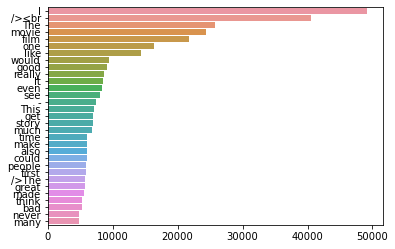

In [23]:
# построим график самых повторяющихся слов
corpus=[]
for comments, _ in raw_train_ds:
      for x in comments.numpy():
        for i in str(x).split():
          corpus.append(i)
counter=Counter(corpus)
most_common=counter.most_common()
x, y = [], []
for word,count in most_common[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

In [24]:
# remove tags 
def remove_tags(text, label):
    return tf.strings.regex_replace(text, "<br />", " "), label

raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_tags), raw_val_ds.map(remove_tags), raw_test_ds.map(remove_tags)

In [25]:
#Removes Punctuations
def remove_punctuations(text, label):
    return tf.strings.regex_replace(text, '[^\w\s]', ''), label

#Removes HTML syntaxes
def remove_html(text, label):
    return tf.strings.regex_replace(text, '<.*?>', ''), label

#Removes URL data
def remove_url(text, label):
    return tf.strings.regex_replace(text, 'https://\S+|www\.\S+', ''), label

#Removes Emojis
def remove_emoji(text, label):
    text = tf.strings.regex_replace(text, "["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", '')
    return tf.strings.regex_replace(text, 'https://\S+|www\.\S+', ''), label

raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_punctuations), raw_val_ds.map(remove_punctuations), raw_test_ds.map(remove_punctuations)
raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_html), raw_val_ds.map(remove_html), raw_test_ds.map(remove_html)
raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_url), raw_val_ds.map(remove_url), raw_test_ds.map(remove_url)
raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_emoji), raw_val_ds.map(remove_emoji), raw_test_ds.map(remove_emoji)

In [26]:
def remove_abb(text, label):
    text = tf.strings.regex_replace(text, "he's", "he is")
    text = tf.strings.regex_replace(text, "there's", "there is")
    text = tf.strings.regex_replace(text, "We're", "We are")
    text = tf.strings.regex_replace(text, "That's", "That is")
    text = tf.strings.regex_replace(text, "won't", "will not")
    text = tf.strings.regex_replace(text, "they're", "they are")
    text = tf.strings.regex_replace(text, "Can't", "Cannot")
    text = tf.strings.regex_replace(text, "wasn't", "was not")
    text = tf.strings.regex_replace(text, "don\x89Ûªt", "do not")
    text= tf.strings.regex_replace(text, "aren't", "are not")
    text = tf.strings.regex_replace(text, "isn't", "is not")
    text = tf.strings.regex_replace(text, "What's", "What is")
    text = tf.strings.regex_replace(text, "haven't", "have not")
    text = tf.strings.regex_replace(text, "hasn't", "has not")
    text = tf.strings.regex_replace(text, "There's", "There is")
    text = tf.strings.regex_replace(text, "He's", "He is")
    text = tf.strings.regex_replace(text, "It's", "It is")
    text = tf.strings.regex_replace(text, "You're", "You are")
    text = tf.strings.regex_replace(text, "I'M", "I am")
    text = tf.strings.regex_replace(text, "shouldn't", "should not")
    text = tf.strings.regex_replace(text, "wouldn't", "would not")
    text = tf.strings.regex_replace(text, "i'm", "I am")
    text = tf.strings.regex_replace(text, "I\x89Ûªm", "I am")
    text = tf.strings.regex_replace(text, "I'm", "I am")
    text = tf.strings.regex_replace(text, "Isn't", "is not")
    text = tf.strings.regex_replace(text, "Here's", "Here is")
    text = tf.strings.regex_replace(text, "you've", "you have")
    text = tf.strings.regex_replace(text, "you\x89Ûªve", "you have")
    text = tf.strings.regex_replace(text, "we're", "we are")
    text = tf.strings.regex_replace(text, "what's", "what is")
    text = tf.strings.regex_replace(text, "couldn't", "could not")
    text = tf.strings.regex_replace(text, "we've", "we have")
    text = tf.strings.regex_replace(text, "it\x89Ûªs", "it is")
    text = tf.strings.regex_replace(text, "doesn\x89Ûªt", "does not")
    text = tf.strings.regex_replace(text, "It\x89Ûªs", "It is")
    text = tf.strings.regex_replace(text, "Here\x89Ûªs", "Here is")
    text = tf.strings.regex_replace(text, "who's", "who is")
    text = tf.strings.regex_replace(text, "I\x89Ûªve", "I have")
    text = tf.strings.regex_replace(text, "y'all", "you all")
    text = tf.strings.regex_replace(text, "can\x89Ûªt", "cannot")
    text = tf.strings.regex_replace(text, "would've", "would have")
    text = tf.strings.regex_replace(text, "it'll", "it will")
    text = tf.strings.regex_replace(text, "we'll", "we will")
    text = tf.strings.regex_replace(text, "wouldn\x89Ûªt", "would not")
    text = tf.strings.regex_replace(text, "We've", "We have")
    text = tf.strings.regex_replace(text, "he'll", "he will")
    text = tf.strings.regex_replace(text, "Y'all", "You all")
    text = tf.strings.regex_replace(text, "Weren't", "Were not")
    text = tf.strings.regex_replace(text, "Didn't", "Did not")
    text = tf.strings.regex_replace(text, "they'll", "they will")
    text = tf.strings.regex_replace(text, "they'd", "they would")
    text = tf.strings.regex_replace(text, "DON'T", "DO NOT")
    text = tf.strings.regex_replace(text, "That\x89Ûªs", "That is")
    text = tf.strings.regex_replace(text, "they've", "they have")
    text = tf.strings.regex_replace(text, "i'd", "I would")
    text = tf.strings.regex_replace(text, "should've", "should have")
    text = tf.strings.regex_replace(text, "You\x89Ûªre", "You are")
    text = tf.strings.regex_replace(text, "where's", "where is")
    text = tf.strings.regex_replace(text, "Don\x89Ûªt", "Do not")
    text = tf.strings.regex_replace(text, "we'd", "we would")
    text = tf.strings.regex_replace(text, "i'll", "I will")
    text = tf.strings.regex_replace(text, "weren't", "were not")
    text = tf.strings.regex_replace(text, "They're", "They are")
    text = tf.strings.regex_replace(text, "Can\x89Ûªt", "Cannot")
    text = tf.strings.regex_replace(text, "you\x89Ûªll", "you will")
    text = tf.strings.regex_replace(text, "I\x89Ûªd", "I would")
    text = tf.strings.regex_replace(text, "let's", "let us")
    text = tf.strings.regex_replace(text, "it's", "it is")
    text = tf.strings.regex_replace(text, "can't", "cannot")
    text = tf.strings.regex_replace(text, "don't", "do not")
    text = tf.strings.regex_replace(text, "you're", "you are")
    text = tf.strings.regex_replace(text, "i've", "I have")
    text = tf.strings.regex_replace(text, "that's", "that is")
    text = tf.strings.regex_replace(text, "i'll", "I will")
    text = tf.strings.regex_replace(text, "doesn't", "does not")
    text = tf.strings.regex_replace(text, "i'd", "I would")
    text = tf.strings.regex_replace(text, "didn't", "did not")
    text = tf.strings.regex_replace(text, "ain't", "am not")
    text = tf.strings.regex_replace(text, "you'll", "you will")
    text = tf.strings.regex_replace(text, "I've", "I have")
    text = tf.strings.regex_replace(text, "Don't", "do not")
    text = tf.strings.regex_replace(text, "I'll", "I will")
    text = tf.strings.regex_replace(text, "I'd", "I would")
    text = tf.strings.regex_replace(text, "Let's", "Let us")
    text = tf.strings.regex_replace(text, "you'd", "You would")
    text = tf.strings.regex_replace(text, "It's", "It is")
    text = tf.strings.regex_replace(text, "Ain't", "am not")
    text = tf.strings.regex_replace(text, "Haven't", "Have not")
    text = tf.strings.regex_replace(text, "Could've", "Could have")
    text = tf.strings.regex_replace(text, "youve", "you have")  
    text = tf.strings.regex_replace(text, "donå«t", "do not") 
    return text, label  
raw_train_ds, raw_val_ds, raw_test_ds = raw_train_ds.map(remove_abb), raw_val_ds.map(remove_abb), raw_test_ds.map(remove_abb)

<AxesSubplot:>

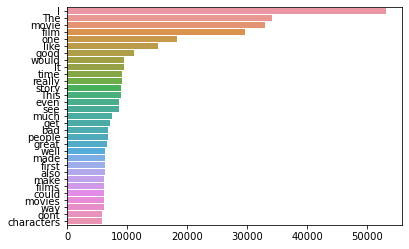

In [27]:
# повторно построим график самых повторяющихся слов
corpus=[]
for comments, _ in raw_train_ds:
      for x in comments.numpy():
        for i in str(x).split():
          corpus.append(i)
counter=Counter(corpus)
most_common=counter.most_common()
x, y = [], []
for word,count in most_common[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

In [32]:
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):
    return tf.strings.lower(input_data)


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

## Two options to vectorize the data

There are 2 ways we can use our text vectorization layer:

**Option 1: Make it part of the model**, so as to obtain a model that processes raw
 strings, like this:

```python
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
...
```

**Option 2: Apply it to the text dataset** to obtain a dataset of word indices, then
 feed it into a model that expects integer sequences as inputs.

An important difference between the two is that option 2 enables you to do
**asynchronous CPU processing and buffering** of your data when training on GPU.
So if you're training the model on GPU, you probably want to go with this option to get
 the best performance. This is what we will do below.

If we were to export our model to production, we'd ship a model that accepts raw
strings as input, like in the code snippet for option 1 above. This can be done after
 training. We do this in the last section.


In [33]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

## Build a model

We choose a simple 1D convnet starting with an `Embedding` layer.

In [39]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = tf.keras.layers.Dense(8, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
#x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
# x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.LSTM(128, return_sequences=True, return_state=False)(x)
x = layers.LSTM(256, return_sequences=True, return_state=False)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
#x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = tf.keras.layers.Dense(8, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

In [ ]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = layers.AveragePooling1D(pool_size = 2)(x)
x = layers.Bidirectional(LSTM(200, dropout = 0.5))(x)
# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = tf.keras.layers.Dense(8, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

In [34]:
inputs = tf.keras.Input(shape=(None,), dtype="int64")
###x = layers.Embedding(129892, 32)(inputs)
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Bidirectional(LSTM(75, dropout = 0.1))(x)
predictions = tf.keras.layers.Dense(8, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

inputs = tf.keras.Input(shape=(None,), dtype="int64")

x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
predictions = tf.keras.layers.Dense(10, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

## Train the model

In [35]:
epochs = 10

# Fit the model using the train and test datasets.
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 210s 332ms/step - loss: 1.8258 - accuracy: 0.3106 - val_loss: 1.6613 - val_accuracy: 0.3642
Epoch 2/10
625/625 [==============================] - 210s 336ms/step - loss: 1.5305 - accuracy: 0.4183 - val_loss: 1.6361 - val_accuracy: 0.3694
Epoch 3/10
625/625 [==============================] - 206s 330ms/step - loss: 1.3959 - accuracy: 0.4693 - val_loss: 1.6953 - val_accuracy: 0.3492
Epoch 4/10
625/625 [==============================] - 207s 331ms/step - loss: 1.2084 - accuracy: 0.5458 - val_loss: 1.7454 - val_accuracy: 0.3520
Epoch 5/10
625/625 [==============================] - 207s 332ms/step - loss: 1.0062 - accuracy: 0.6314 - val_loss: 1.9028 - val_accuracy: 0.3354
Epoch 6/10
625/625 [==============================] - 206s 330ms/step - loss: 0.8878 - accuracy: 0.6848 - val_loss: 2.0475 - val_accuracy: 0.3472
Epoch 7/10
625/625 [==============================] - 198s 316ms/step - loss: 0.7143 - accuracy: 0.7528 - val_loss: 2.2182 -

## Evaluate the model on the test set

In [36]:
model.evaluate(test_ds)

782/782 [==============================] - 48s 61ms/step - loss: 2.8953 - accuracy: 0.3085


[2.895310878753662, 0.30847999453544617]

In [56]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [39]:
!tar -zcvf keras_model.tgz model.json

model.json


## Make an end-to-end model

If you want to obtain a model capable of processing raw strings, you can simply
create a new model (using the weights we just trained):

In [ ]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
end_to_end_model.evaluate(raw_test_ds)

## BERT

In [43]:
!pip install -q -U "tensorflow-text==2.11.*"

In [44]:
!pip install -q tf-models-official==2.11.0

In [53]:
!pip install tensorflow_hub

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
bert_model_name = 'talking-heads_base'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(8, activation="softmax", name='classifier')(net)

    return tf.keras.Model(text_input, net)

In [ ]:
bert_model = build_classifier_model()
bert_raw_result = bert_model(tf.constant(text_test))
print(bert_raw_result)

In [ ]:
tf.keras.utils.plot_model(bert_model)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.Accuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
bert_model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics=["accuracy"])

In [ ]:
# remove tags 
def remove_tags(text, label):
    return tf.strings.regex_replace(text, "<br />", " "), label


raw_train_ds = raw_train_ds.map(remove_tags)
raw_val_ds = raw_val_ds.map(remove_tags)
raw_test_ds = raw_test_ds.map(remove_tags)

raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=10)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=10)
raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=10)

In [ ]:
history = bert_model.fit(raw_train_ds,
                               validation_data=raw_val_ds,
                               epochs=epochs)

In [ ]:
loss, accuracy = classifier_model.evaluate(raw_test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 101s 128ms/step - loss: 1.6138 - accuracy: 0.3978
Loss: 1.6138099431991577
Accuracy: 0.3978399932384491
